In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec # For customizing the suabplots spacing
import pandas as pd
import polars as pl
import os

In [2]:
from sklearn.decomposition import FastICA
import scipy
import scipy.signal as scsig

In [3]:
from laser_dataset import FileReader
from synchronization import Synchronizer


## Steps for synchronization
- (0) Load the metadata (Versuchstabelle) -> to identify the file names (soundbook, QASS)
- (1) Load the QASS signals 
    - synch signal = Ch.4
    - Zeor-mean and normalization computed in the synchornizer class
- (2) Load and process the Dewetron signal (to compensate the different sampling rate)
    - (2.1) Load + zero-mean & normalize
    - (2.2) Linear interpolation
- (3) Cross-correlate the interpolated Dewetron signal and the IDMT data
- (4) Identify the delay (i.e. peak)

## (0) Load the meta data (Versuchstabelle) -> for file names

In [4]:
path_meta = '/Volumes/Sandisk_SD/Work/IZFP/Laser/2023_iHub/00_Versuchsplan_iHub.xlsx'
metadf = pd.read_excel(
    path_meta,
    sheet_name=1,
    usecols="B:F",
    nrows=71
)

In [5]:
# Path to the data
path_dew = '/Volumes/Sandisk_SD/Work/IZFP/Laser/2023_iHub/01_DEWETRON_csv'
path_izfp = '/Volumes/Sandisk_SD/Work/IZFP/Laser/2023_iHub/02_QASS'

# Example trial
dataID = 14#57
row = dataID - 1 #22, 27, 30, 39, 40, 43, 44 -> negative delay
fname_dew = metadf['DEWETRON'][row]
qassNo = str(metadf['QASS'][row]).zfill(3)
print(qassNo)

058


## (1) Load the QASS data

In [6]:
synch = Synchronizer()
# Load the derivative of the synch signal (Ch.4)
t_izfp, s_izfp = synch.load_qass(path_izfp, qassNo)


## Check the Dewetron difference signal

In [7]:
# Load the derivative of the synch signal of the Dewetron
t_dew, s_dew = synch.load_dew(path_dew, fname_dew, sigtypes=['Sync/Derivative_V/s'])
# Zero-mean and normalize
s_dew = s_dew - s_dew.mean()
s_dew = s_dew / np.abs(s_dew).max()


## (3) + (4): interpolation -> cross-correlation

In [8]:
# Parameters w.r.t. the synch signal
# N = T_synch / fs_dew -> available as synch.N
# fs for Dewetron and QASS -> synch.fs_dew, synch.fs_izfp

# # Intepolation -> duration = [0.0, T4]s
t_interp, s_interp = synch.interpolate(t_dew, s_dew, t_izfp, synch.fs_izfp)
# (4) Identify the delay
delay, N_offset, corr, tau = synch.identify_delay(s_interp, s_izfp, synch.fs_izfp, ret_corr=True)


Synchronizer: returning the correlation results


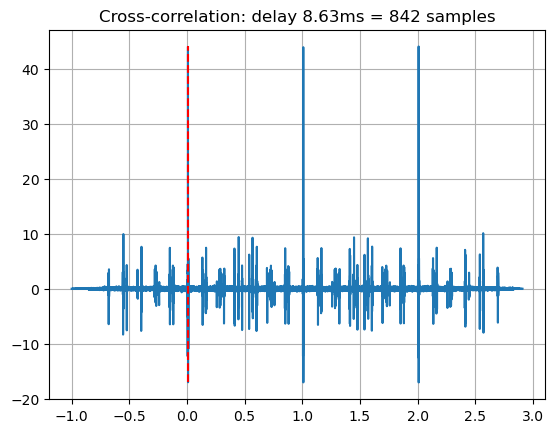

In [9]:
plt.figure()
plt.title(f'Cross-correlation: delay {round(delay*10**3, 2)}ms = {N_offset} samples')
plt.plot(tau, corr)
plt.vlines(x=delay, ymin=corr.min(), ymax=corr.max(), linestyles='--', color='r')
plt.grid(True)

In [10]:
def save_allplots(save, fname=None):

    # Subplots spacing
    plt.rcParams["figure.figsize"] = [6.50, 4.50]
    plt.rcParams["figure.autolayout"] = True
    gs1 = gridspec.GridSpec(3, 1)
    gs1.update(wspace=0.0, hspace=0.15)

    # Axis labels
    plt.rcParams['axes.titlesize'] = 12
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=False)
    #plt.suptitle(f'Delay correction of {fname_dew}: {round(delay*10**3, 3)}ms delay')
    plt.subplots_adjust(hspace=0.6) # more spacing between rows

    # Before
    ax0.plot(t_dew, s_dew, label='DEW deriv.')
    ax0.plot(t_izfp, s_izfp, label='QASS before')
    ax0.set_xlabel('Aufnahmezeit [s]')
    ax0.set_ylabel('[V]')
    ax0.legend(loc='upper right')
    ax0.grid(True)
    ax0.set_xlim(-0.5, 2.5)

    # After
    ax1.sharex(ax0)
    
    ax1.plot(t_dew, s_dew, label='DEW deriv.')
    ax1.plot(t_izfp-delay, s_izfp, label= f'QASS after')
    ax1.set_xlabel('Aufnahmezeit [s]')
    ax1.set_ylabel('[V]')
    ax1.legend(loc='upper right')
    ax1.grid(True)

    # Cross-correlation results
    _corr = corr/np.abs(corr).max()
    ax2.plot(tau, _corr, label='cross correlation')
    peaks = delay
    ax2.vlines(x=peaks, ymin=_corr.min(), ymax=_corr.max(), linestyles='--', color='r')
    ax2.set_xlabel('Versatz [s]')
    ax2.set_ylabel(r"[$V^2$]")
    #ax2.legend(loc='upper right')
    xticks = np.sort(np.concatenate((np.array([peaks]), np.array([-1.0, 1.0, 2.0, 3.0]))))
    ax2.set_xticks(xticks)
    ax2.grid(True)

    if save == True:
        # Parameters for savefig
        # dpi > 150 does not yield any perceptible difference in resolution 
        # bbox_inches: bounding box to determine the area to be saved => use 'tight', otherwise including a weird white space
        # pad_inches: margine to be padded, if bbox_inches == 'tight'
        plt.savefig(
            fname, 
            dpi=250, 
            bbox_inches = 'tight', 
            pad_inches = 0.1 #pad_inches = 0.05
        ) 

    plt.show()
    

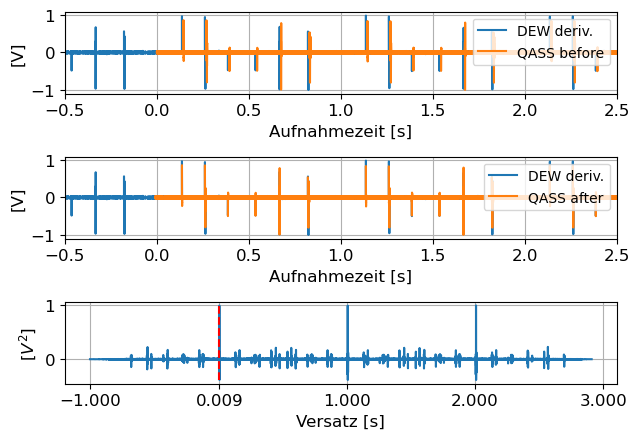

In [11]:
save_allplots(save=True, fname='plots/ihub_qass_synchronization.png')

In [ ]:
#plt.close('all')

In [ ]:
%matplotlib widget
#%matplotlib inline

fig, ax0 = plt.subplots(nrows=1)
plt.suptitle(f'Delay correction of {fname_dew}: {round(delay*10**3, 3)}ms delay')
plt.subplots_adjust(hspace=0.6) # more spacing between rows

# Before
ax0.plot(t_dew, s_dew, label='DEW deriv')
ax0.plot(t_izfp, s_izfp, alpha=0.7, label='QASS before')
#ax0.plot(t_izfp-delay, s_izfp, label= f'QASS after', linestyle=':')
ax0.set_xlabel('trigger time [s]')
ax0.legend(loc='upper right')
ax0.grid(True)


In [ ]:
#plt.close('all')

## Stats of the delays

In [ ]:
df_delays = pd.read_csv(
    '/Volumes/Sandisk_SD/Work/IZFP/Laser/2023_iHub/04_Delays/delays_QASS.csv'
)
# Average delay between Soundbook and Dewetron
print('Mean:')
print(df_delays['delay[s]'].mean())
print('Std:')
print(df_delays['delay[s]'].std())

In [ ]:
# Exclude the outlier
print('Outlier:')
print(df_delays['DEWETRON'][63])
print(df_delays['delay[s]'][63])

new_df = df_delays.drop(index=63)
# Average delay without the outlier
print('Mean without the outlier:')
print(new_df['delay[s]'].mean())
print('Std without the outlier:')
print(new_df['delay[s]'].std())

In [ ]:
raise ValueError('Stop!')

## Get the delays for all trials

In [ ]:
# Path to the data
path_dew = '/Volumes/Sandisk_SD/Work/IZFP/Laser/2023_iHub/01_DEWETRON_csv'
path_izfp = '/Volumes/Sandisk_SD/Work/IZFP/Laser/2023_iHub/02_QASS'

# Files name setting
fname_prefix = '20231016_TU_Ilmenau_Process'
fname_suffix = 'SIG_Raw_compress_1'
    
# Base
info_dict = {
    'dataID' : [],
    'DEWETRON': [],
    'QASS': [],
    'delay[s]': []
}

for row in np.arange(len(metadf)):
    ##### Specify the name
    dataID = row + 1
    fname_dew = metadf['DEWETRON'][row]
    qassNo = str(metadf['QASS'][row]).zfill(3)
    fname_izfp = f'{fname_prefix}_{qassNo}_Ch4_{fname_suffix}'
    print(f'dataID = {dataID}, name = {fname_dew} = {fname_izfp}')
    
    ##### Synchronize
    synch = Synchronizer()
    
    #---- (1) QASS data = the derivative of the synch signal (Ch.4)
    t_izfp, s_izfp = synch.load_qass(path_izfp, qassNo)
    
    #---- (2) Process Dewetron data = derivative of the synch signal
    t_dew, s_dew = synch.load_dew(path_dew, fname_dew, sigtypes=['Sync/Derivative_V/s'])
    # Zero-mean and normalize
    s_dew = s_dew - s_dew.mean()
    s_dew = s_dew / np.abs(s_dew).max()
    # Intepolation -> duration = same length as s_izfp
    t_interp, s_interp = synch.interpolate(t_dew, s_dew, t_izfp, synch.fs_izfp)
    
    #---- (3) Identify the delay: cross-correlate (1) and (2) 
    delay, N_offset = synch.identify_delay(s_interp, s_izfp, synch.fs_izfp)
    
    #---- Update the info dictionary
    info_dict['dataID'].append(dataID)
    info_dict['DEWETRON'].append(fname_dew)
    info_dict['QASS'].append(qassNo)
    info_dict['delay[s]'].append(round(delay, 9))

In [ ]:
# Convert the dictionary to a dataframe
info_df = pd.DataFrame.from_dict(info_dict, orient='columns')
# Print
info_df

In [ ]:
# Save the dataframe as csv
path2save = '/Volumes/Sandisk_SD/Work/IZFP/Laser/2023_iHub/04_Delays'
info_df.to_csv(f'{path2save}/delays_QASS.csv', index=False)


## Analyze the delay data 

In [ ]:
read = True
if read == True:
    path_rel = '/Volumes/Sandisk_SD/Work/IZFP/Laser/2023_iHub/04_Delays'
    info_df = pd.read_csv(f'{path_rel}/delays_QASS.csv')

In [ ]:
info_df

In [ ]:
info_df['delay[s]'][info_df['delay[s]']>10*10**-3]

In [ ]:
print('Max delay =')
print(info_df['delay[s]'].max())
print('@')
print(info_df['delay[s]'].argmax())
print('Trial No.')
print(info_df['DEWETRON'][info_df['delay[s]'].argmax()])

In [ ]:
%matplotlib widget
hist = info_df['delay[s]'].hist(bins=[-0.1, -0.01, -0.001, 0.0, 10**-3, 0.01, 0.1, 0.2, 0.4, 0.5, 0.6])

In [ ]:
arr.max()

In [ ]:
plt.close('all')